In [1]:
# Name: probabilistic_model_constructions.ipynb
# Authors: Stephan Meighen-Berger
# Constructs a probabilistic model which can be used instead of the cpu heavy simulation
# Still in BETA!!!

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from tqdm import tqdm
import pickle

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config
from fourth_day.pdfs import construct_pdf

In [6]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.

In [7]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [8]:
# Some example settings
config['scenario']['population size'] = 2
config['scenario']['duration'] = 6000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 1e0
config['scenario']['light prop'] = {
            "switch": False,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "switch": False,
}
# Organisms
config['organisms']['emission fraction'] = 0.1
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    "offset": np.array([0., 0.]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 2.,
    "y_pos": 5.,
}
# Water
config['water']['model']['name'] = 'custom' # using grid files
config['water']['model']['off set'] = np.array([0., 2.5])
config['water']['model']['directory'] = "../data/current/Long_run_corr/"
config['water']['model']['time step'] = 0.1
config['advanced']['starting step'] = 0

In [9]:
runs = 10
alphas = [1e1, 1e0, 1e-1]
y_ranges = [
    [[4.9, 5.1], '0'],
    [[5.9, 6.1], '1'],
    [[6.9, 7.1], '2'],
    [[7.9, 8.1], '3'],
    [[9.9, 10.1], '5']
]
for y_range in y_ranges:
    alpha_x_arr = []
    alpha_norm_arr = []
    config['scenario']['injection']['y range'] = y_range[0]
    for alpha in alphas:
        run_x = []
        run_norm = []
        for seed in tqdm(range(runs)):
            # Create new data
            config['scenario']['class'] = 'New'
            config['scenario']["statistics storage"]["name"] = (
                "probabilistic_offcenter_%s_alpha_%d_seed_%d" %(y_range[1], int(np.log10(alpha)), int(seed))
            )
            # Seed
            config['general']["random state seed"] = seed
            # Alpha
            config['organisms']['alpha'] = alpha
            # Creating a fourth_day object
            fd = Fourth_Day()
            # Launching solver
            fd.sim()
            # Analyzing data
            x_loc = []
            for stat in fd.statistics:
                tmp = stat["pos_x"].values[stat["pulse start"].values]
                if len(tmp) > 0:
                    x_loc.append(tmp)
                else:
                    continue
            try:
                x_loc = np.concatenate(x_loc).ravel()
                run_x.append(x_loc)
            except:
                continue
            # Normalization
            norm_fac = []
            for x_l in x_loc:
                norm_fac.append(len(
                    fd.statistics[-1]["pos_x"].values[np.where(fd.statistics[-1]["pos_x"].values >= x_l ) ]
                ))
            norm_fac = np.array(norm_fac)
            run_norm.append(norm_fac)
        run_x = np.concatenate(run_x).ravel()
        run_norm = np.concatenate(run_norm).ravel() * runs
        alpha_x_arr.append(run_x)
        alpha_norm_arr.append(run_norm)
    to_dump = {
        'alphas': alphas,
        'x_arr': alpha_x_arr,
        'norm': alpha_norm_arr
    }
    pickle.dump(to_dump, open("offcenter_v3_%s.p" % y_range[1], "wb" ) )

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [45:14<00:00, 271.42s/it]


In [17]:
data_0 = pickle.load( open("probability_model/offcenter_v3_0.pkl", "rb" ) )
data_1 = pickle.load( open("probability_model/offcenter_v3_1.pkl", "rb" ) )
data_2 = pickle.load( open("probability_model/offcenter_v3_2.pkl", "rb" ) )
data_3 = pickle.load( open("probability_model/offcenter_v3_3.pkl", "rb" ) )
data_5 = pickle.load( open("probability_model/offcenter_v3_5.pkl", "rb" ) )

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


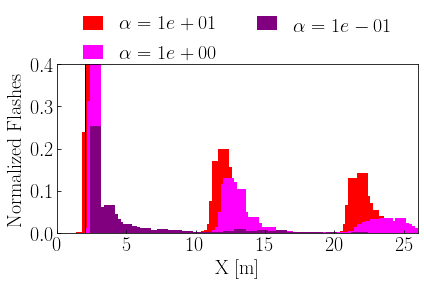

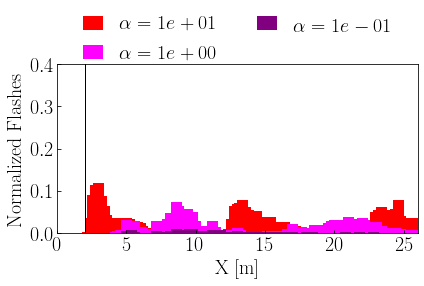

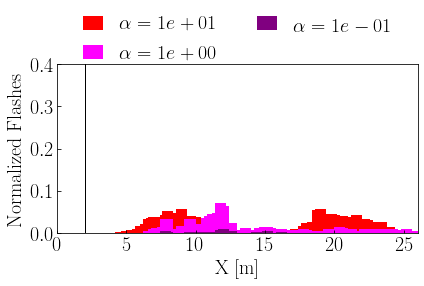

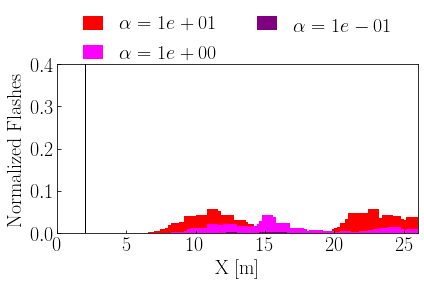

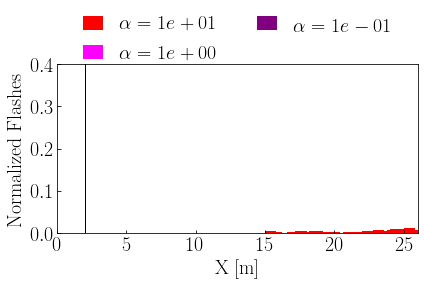

In [18]:
# Probability distributions 0
edgecolors = ['r', 'magenta', 'purple', 'b']
alphas_plt = [1., 1., 1., 1.]
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
for id_alpha, alpha in enumerate(data_0['alphas']):
    counts, edges = np.histogram(data_0['x_arr'][id_alpha],
                        bins=np.linspace(0., 26., 131),
                        weights=1./data_0['norm'][id_alpha]
                        )
    hist = ax1.bar(edges[:-1],
                    counts,
                    color=edgecolors[id_alpha],
                    alpha=alphas_plt[id_alpha],
                    label=r'$\alpha = %.e$' % alpha,
                    lw=lw)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{X}\;[\mathrm{m}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Normalized\;Flashes}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.axvline(2., color='k', lw=lw)
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.4),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(0., 0.4)
ax1.set_xlim(0., 26.)
plt.tight_layout()
plt.show()
figure.savefig(PICS + "0_prob.png",
               bbox_inches='tight')
# Probability distributions 1
edgecolors = ['r', 'magenta', 'purple', 'b']
alphas_plt = [1., 1., 1., 1.]
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
for id_alpha, alpha in enumerate(data_1['alphas']):
    counts, edges = np.histogram(data_1['x_arr'][id_alpha],
                        bins=np.linspace(0., 26., 131),
                        weights=1./data_1['norm'][id_alpha]
                        )
    hist = ax1.bar(edges[:-1],
                    counts,
                    color=edgecolors[id_alpha],
                    alpha=alphas_plt[id_alpha],
                    label=r'$\alpha = %.e$' % alpha,
                    lw=lw)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{X}\;[\mathrm{m}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Normalized\;Flashes}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.axvline(2., color='k', lw=lw)
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.4),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(0., 0.4)
ax1.set_xlim(0., 26.)
plt.tight_layout()
plt.show()
figure.savefig(PICS + "1_prob.png",
               bbox_inches='tight')
# Probability distributions 2
edgecolors = ['r', 'magenta', 'purple', 'b']
alphas_plt = [1., 1., 1., 1.]
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
for id_alpha, alpha in enumerate(data_2['alphas']):
    counts, edges = np.histogram(data_2['x_arr'][id_alpha],
                        bins=np.linspace(0., 26., 131),
                        weights=1./data_2['norm'][id_alpha]
                        )
    hist = ax1.bar(edges[:-1],
                    counts,
                    color=edgecolors[id_alpha],
                    alpha=alphas_plt[id_alpha],
                    label=r'$\alpha = %.e$' % alpha,
                    lw=lw)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{X}\;[\mathrm{m}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Normalized\;Flashes}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.axvline(2., color='k', lw=lw)
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.4),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(0., 0.4)
ax1.set_xlim(0., 26.)
plt.tight_layout()
plt.show()
figure.savefig(PICS + "2_prob.png",
               bbox_inches='tight')
# Probability distributions 3
edgecolors = ['r', 'magenta', 'purple', 'b']
alphas_plt = [1., 1., 1., 1.]
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
for id_alpha, alpha in enumerate(data_3['alphas']):
    counts, edges = np.histogram(data_3['x_arr'][id_alpha],
                        bins=np.linspace(0., 26., 131),
                        weights=1./data_3['norm'][id_alpha]
                        )
    hist = ax1.bar(edges[:-1],
                    counts,
                    color=edgecolors[id_alpha],
                    alpha=alphas_plt[id_alpha],
                    label=r'$\alpha = %.e$' % alpha,
                    lw=lw)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{X}\;[\mathrm{m}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Normalized\;Flashes}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.axvline(2., color='k', lw=lw)
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.4),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(0., 0.4)
ax1.set_xlim(0., 26.)
plt.tight_layout()
plt.show()
figure.savefig(PICS + "3_prob.png",
               bbox_inches='tight')
# Probability distributions 5
edgecolors = ['r', 'magenta', 'purple', 'b']
alphas_plt = [1., 1., 1., 1.]
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
for id_alpha, alpha in enumerate(data_5['alphas']):
    counts, edges = np.histogram(data_5['x_arr'][id_alpha],
                        bins=np.linspace(0., 26., 131),
                        weights=1./data_5['norm'][id_alpha]
                        )
    hist = ax1.bar(edges[:-1],
                    counts,
                    color=edgecolors[id_alpha],
                    alpha=alphas_plt[id_alpha],
                    label=r'$\alpha = %.e$' % alpha,
                    lw=lw)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{X}\;[\mathrm{m}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Normalized\;Flashes}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.axvline(2., color='k', lw=lw)
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.4),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(0., 0.4)
ax1.set_xlim(0., 26.)
plt.tight_layout()
plt.show()
figure.savefig(PICS + "5_prob.png",
               bbox_inches='tight')